In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random
import math
import pandas as pd
import tqdm
import seaborn as sns

from pymonntorch import *
from conex import *

# CUSTOMIZATION

In [8]:
"""
Population size
"""
N = 50 
E = int(0.8 * N)
I = int(0.2 * N)

"""
Number of classes
"""
K = 5

# NETWORK CREATION

In [60]:
net = Network(behavior = prioritize_behaviors([
    TimeResolution(dt = 1)
]))

E_NG_list = []
for i in range(K) : 
    E_NG = NeuronGroup(net = net,
        size = E,
        behavior = prioritize_behaviors([
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                R = 10,
                tau = 5,
                threshold = -10,
                v_rest = -65,
                v_reset = -67,
                init_v =  -65,
            ),
            InherentNoise(scale=random.randint(20, 60)),
            Fire(),
            NeuronAxon()
        ]) | ({ 
            600 : Recorder(["I"]),
            601 : EventRecorder(['spikes'])
        })
    )

    E_NG_list.append(E_NG)


I_NG = NeuronGroup(net = net,
    size = I * K,
    tag = "inh",
    behavior = prioritize_behaviors([
        SimpleDendriteStructure(),
        SimpleDendriteComputation(),
        LIF(
            R = 10,
            tau = 5,
            threshold = -10,
            v_rest = -65,
            v_reset = -67,
            init_v =  -65,
        ),
        Fire(),
        NeuronAxon()
    ]) | ({ 
        600 : Recorder(["I"]),
        601 : EventRecorder(['spikes'])
    })
)


for i in range(K) : 

    EE_SYN = SynapseGroup(
        net = net,
        src = E_NG_list[i], 
        dst = E_NG_list[i], 
        tag = "Proximal, EXI",
        behavior = prioritize_behaviors([
            SynapseInit(),
            WeightInitializer(mode = "random"),
            SimpleDendriticInput(),
        ])
    )

    IE_SYN = SynapseGroup(
        net = net,
        src = I_NG, 
        dst = E_NG_list[i], 
        tag = "Proximal, inh",
        behavior = prioritize_behaviors([
            SynapseInit(),
            WeightInitializer(mode = 4),
            SimpleDendriticInput(),
        ])
    )

    EI_SYN = SynapseGroup(
        net = net,
        src = E_NG_list[i], 
        dst = I_NG, 
        tag = "Proximal, EXI",
        behavior = prioritize_behaviors([
            SynapseInit(),
            WeightInitializer(mode = "random"),
            SimpleDendriticInput(),
        ])
    )

In [61]:
net.initialize()
net.simulate_iterations(100)

Network['Network'](Neurons: tensor(250)|6 groups, Synapses: tensor(28000)|15 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](40){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=10,tau=5,threshold=-10,v_reset=-67,v_rest=-65,init_v=-65,init_s=None,)280:InherentNoise(mode=rand,scale=45,offset=0,)340:Fire()380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)600:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['I'],)601:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spikes'],)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](40){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=

375.9932518005371

# VISUALIZATION

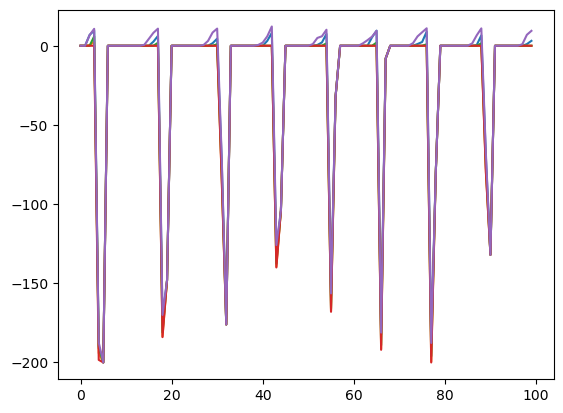

In [62]:
for i in range(K) : 
    plt.plot(torch.sum(net.NeuronGroups[i]['I', 0][:], axis = 1)/net.NeuronGroups[i].size)
plt.show()

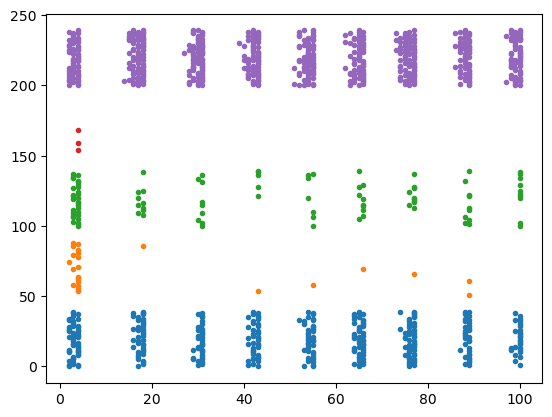

In [63]:
for i in range(K) : 
    plt.plot(net.NeuronGroups[i]['spikes.t', 0], net.NeuronGroups[i]['spikes.i', 0] + (i * 50), '.')

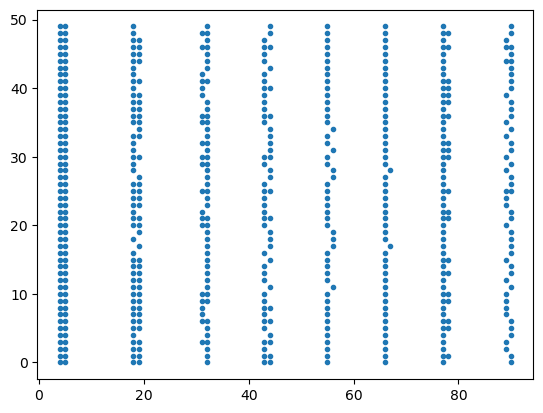

In [64]:
plt.plot(I_NG['spikes.t', 0], I_NG['spikes.i', 0], '.')

# INCAPSOLATION

In [83]:
class FC() :
    """
    Fully Connected Layer works as the decision making layer (Classifier) using EI populations and competition.
    """

    def __init__(self, K, N) : 
        """
        Creates the Network of Neural Poplations and their Synapses to be ready for the ouside input current.

        Args : 
            (int) K: number of classes/excitatory NeuronGroups to be created.
            (int) N: size of each neuron group (due to 80-20 exi-inh distribution, 
                                                size of each exi population would be 0.8 * N)
            (Layer) INP : Neural Layer to be connected to the FC layer.
        """

        self.N = N
        self.E = int(0.8 * N)
        self.I = int(0.2 * N)
        self.K = K




        self.net = Network(behavior = prioritize_behaviors([
            TimeResolution(dt = 1)
        ]))


        """
        Creation of each EXI neuron group.
        """

        self.E_NG_list = []
        for i in range(self.K) : 
            E_NG = NeuronGroup(net = self.net,
                size = self.E,
                behavior = prioritize_behaviors([
                    SimpleDendriteStructure(),
                    SimpleDendriteComputation(),
                    LIF(
                        R = 10,
                        tau = 5,
                        threshold = -10,
                        v_rest = -65,
                        v_reset = -67,
                        init_v =  -65,
                    ),
                    InherentNoise(scale=random.randint(20, 60)),
                    Fire(),
                    NeuronAxon()
                ]) | ({ 
                    600 : Recorder(["I"]),
                    601 : EventRecorder(['spikes'])
                })
            )

            self.E_NG_list.append(E_NG)

        """
        Creation of the single, shared INH neuron group.
        """

        self.I_NG = NeuronGroup(net = self.net,
            size = self.I * self.K,
            tag = "inh",
            behavior = prioritize_behaviors([
                SimpleDendriteStructure(),
                SimpleDendriteComputation(),
                LIF(
                    R = 10,
                    tau = 5,
                    threshold = -10,
                    v_rest = -65,
                    v_reset = -67,
                    init_v =  -65,
                ),
                Fire(),
                NeuronAxon()
            ]) | ({ 
                600 : Recorder(["I"]),
                601 : EventRecorder(['spikes'])
            })
        )

        """
        Creation of Synapses between each EXI to themselves and bidirectional connectivity to INH population.
        """

        for i in range(self.K) : 

            EE_SYN = SynapseGroup(
                net = self.net,
                src = self.E_NG_list[i], 
                dst = self.E_NG_list[i], 
                tag = "Proximal, EXI",
                behavior = prioritize_behaviors([
                    SynapseInit(),
                    WeightInitializer(mode = "random"),
                    SimpleDendriticInput(),
                ])
            )

            IE_SYN = SynapseGroup(
                net = self.net,
                src = self.I_NG, 
                dst = self.E_NG_list[i], 
                tag = "Proximal, inh",
                behavior = prioritize_behaviors([
                    SynapseInit(),
                    WeightInitializer(mode = 4),
                    SimpleDendriticInput(),
                ])
            )

            EI_SYN = SynapseGroup(
                net = self.net,
                src = self.E_NG_list[i], 
                dst = self.I_NG, 
                tag = "Proximal, EXI",
                behavior = prioritize_behaviors([
                    SynapseInit(),
                    WeightInitializer(mode = "random"),
                    SimpleDendriticInput(),
                ])
            )
    
    def initialize(self, has_init = True) :
        self.net.initialize(has_init)

    def simulate_iterations(self, iterations) : 
        self.net.simulate_iterations(iterations)


In [84]:
fclayer = FC(K = K, N = N)
fclayer.initialize()
fclayer.simulate_iterations(100)

Network['Network'](Neurons: tensor(250)|6 groups, Synapses: tensor(28000)|15 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](40){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=10,tau=5,threshold=-10,v_reset=-67,v_rest=-65,init_v=-65,init_s=None,)280:InherentNoise(mode=rand,scale=22,offset=0,)340:Fire()380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)600:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['I'],)601:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spikes'],)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](40){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=

100xBatch: 1/1 (100%) 454.783ms


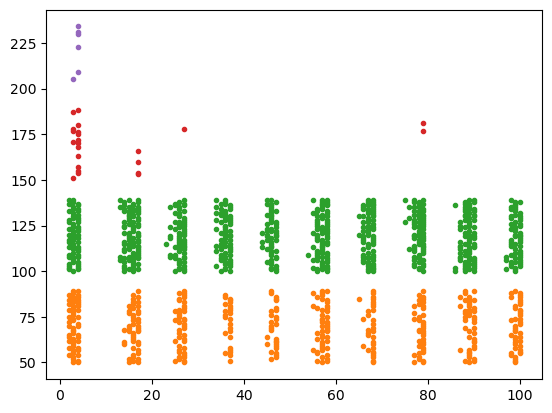

In [85]:
for i in range(fclayer.K) : 
    plt.plot(fclayer.net.NeuronGroups[i]['spikes.t', 0], fclayer.net.NeuronGroups[i]['spikes.i', 0] + (i * 50), '.')